In [50]:
# data tools
import os
import sys
sys.path.append(os.path.join(".."))
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import pandas as pd
import re
#Import shutil and random
import os, sys
import shutil
import random
from shutil import copyfile

# sklearn tools
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

# tf tools
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, 
                                     MaxPooling2D, 
                                     Activation, 
                                     Flatten, 
                                     Dense)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

In [17]:
#data_path = os.path.join("..","data","training")
#outpath = os.path.join("..", "data", "training", "small_training")

In [3]:
# We want to sample the data with 40 test images and 10 validation images for each artist

In [85]:
''' Making the datasets ''''''
#First we make the training dataset

#folder which contains the sub directories we want to copy
source_dir = '../data/training/training/'
#list sub directories 
for root, dirs, files in os.walk(source_dir):

#iterate through them
    for i in dirs: 

        #create a new folder with the name of the iterated sub dir (small_training)
        path = '../data/training/small_training/' + "%s/" % i
        os.makedirs(path)

        #take random sample, here 40 files per sub dir
        filenames = random.sample(os.listdir('../data/training/training/' + "%s/" % i ), 40)

        #copy the files to the new destination
        for j in filenames:
            shutil.copy2('../data/training/training/' + "%s/" % i  + j, path)

'''
       

In [87]:
#Next we do the small validation dataset of 10 images pr. painter

In [88]:
''' Validation set
#folder which contains the sub directories we want to copy
val_source_dir = '../data/validation/validation/'
#list sub directories 
for root, dirs, files in os.walk(val_source_dir):

#iterate through them
    for i in dirs: 

        #create a new folder with the name of the iterated sub dir (small_training)
        path = '../data/validation/small_validation/' + "%s/" % i
        os.makedirs(path)

        #take random sample, here 10 files per sub dir
        filenames = random.sample(os.listdir('../data/validation/validation/' + "%s/" % i ), 10)

        #copy the files to the new destination
        for j in filenames:
            shutil.copy2('../data/validation/validation/' + "%s/" % i  + j, path)

'''

In [51]:
#Path to training folder with painters
training_dir = os.path.join("..", "data", "training", "small_training")

#Names as a string
label_names = []
#Training labels
trainY = []

#For the labels we find the painters 
i = 0
for folder in Path(training_dir).glob("*"):
    #find the painters name with regex
    painter = re.findall(r"(?!.*/).+", str(folder)) #re.findall returns a list 
    #append the list with painters
    label_names.append(painter[0])
    
    
    for img in folder.glob("*"):
        trainY.append(i)
        
    i +=1

In [52]:
#Labels for validation
#Path to training folder with painters
validation_dir = os.path.join("..", "data", "validation", "small_validation")

#test labels
testY = []


i = 0
for folder in Path(validation_dir).glob("*"):
    for img in folder.glob("*"):
        testY.append(i)
    i +=1

In [53]:
# integers to one-hot vectors
lb = LabelBinarizer()
# transform labels to binary codes 
trainY = lb.fit_transform(trainY)
testY = lb.fit_transform(testY)

In [54]:
label_names[5]

'Sargent'

In [55]:
trainY[395]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [56]:
# Change size of images in small_training
# The path were the images are located
filepath = os.path.join("..","data", "training", "small_training")

#create the list
trainX=[]

#loop through all the folders
for folder in Path(filepath).glob("*"):
    #loop through all the files
    for file in Path(folder).glob("*"):
        #read images
        image_open = cv2.imread(str(file))
        #save dimensions
        dim = (120, 120)
        #resize images
        resize_image = cv2.resize(image_open, dim, interpolation = cv2.INTER_AREA)
        #append images to trainX
        trainX.append(resize_image.astype("float") / 255.)


In [57]:
# Change size of images in validation_training
# The path were the images are located
filepath = os.path.join("..","data", "validation", "small_validation")

testX=[]
# Same as before but with the validation images
for folder in Path(filepath).glob("*"):
    for file in Path(folder).glob("*"):
        image_open = cv2.imread(str(file))
        dim = (120, 120)
        resize_image = cv2.resize(image_open, dim, interpolation = cv2.INTER_AREA)
        testX.append(resize_image.astype("float") / 255.)

In [58]:
len(testX)

100

In [59]:
#Convert to numpy
testX = np.array(testX)
trainX = np.array(trainX)

## Plot history model

In [82]:
def plot_history(H, epochs):
    # visualize performance
    plt.style.use("fivethirtyeight")
    fig = plt.figure()
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig("../output/performance.png")

## LeNet model

In [61]:

# define model
model = Sequential()

# first set of CONV => RELU => POOL
model.add(Conv2D(32, (3, 3), 
                 padding="same", 
                 input_shape=(120, 120, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), 
                       strides=(2, 2)))

# second set of CONV => RELU => POOL
model.add(Conv2D(50, (5, 5), 
                 padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), 
                       strides=(2, 2)))

# FC => RELU
model.add(Flatten())
model.add(Dense(500))
model.add(Activation("relu"))

# softmax classifier
model.add(Dense(10))
model.add(Activation("softmax"))

In [62]:
#Compile model

In [63]:
opt = SGD(lr=0.01)
model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

In [64]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 120, 120, 32)      896       
_________________________________________________________________
activation_16 (Activation)   (None, 120, 120, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 60, 60, 50)        40050     
_________________________________________________________________
activation_17 (Activation)   (None, 60, 60, 50)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 30, 30, 50)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 45000)            

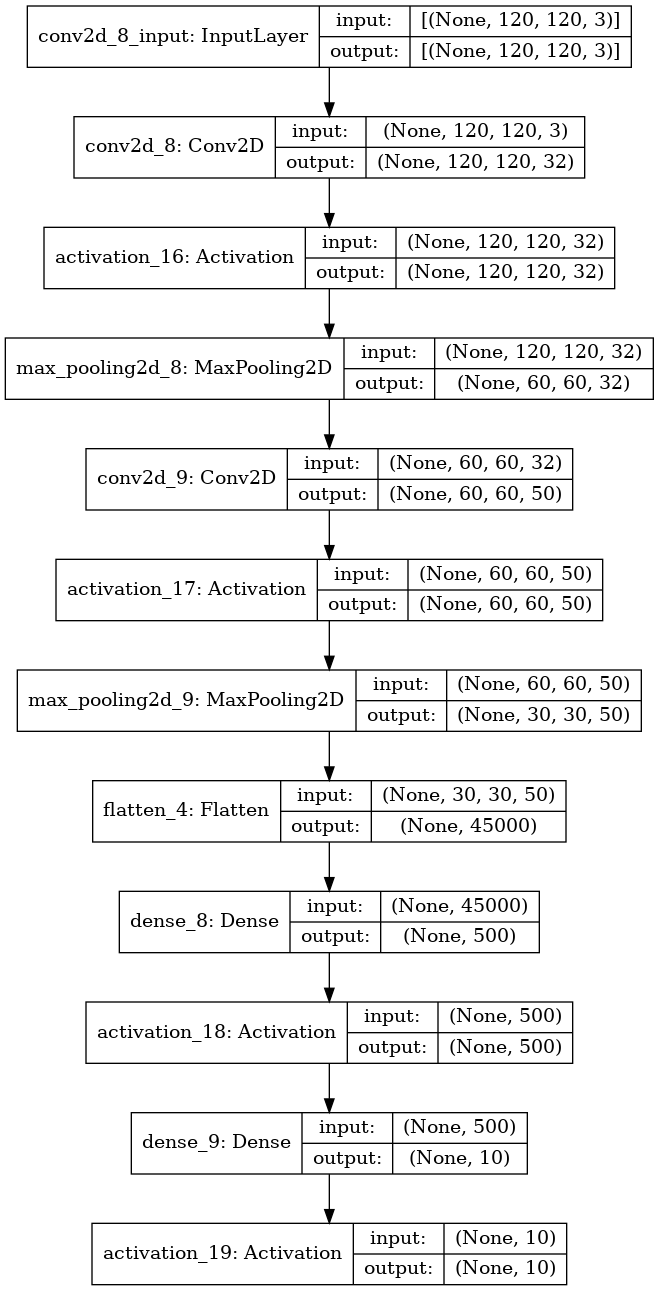

In [81]:
plot_model(model, to_file = "../output/plot_model.png", show_shapes=True, show_layer_names=True)

In [74]:
# train model
H = model.fit(trainX, trainY, 
              validation_data=(testX, testY), 
              batch_size=32,
              epochs=20,
              verbose=1)

Epoch 1/20
13/13 [==============================] - 4s 309ms/step - loss: 2.1137 - accuracy: 0.2625 - val_loss: 2.1896 - val_accuracy: 0.1600
Epoch 2/20
13/13 [==============================] - 4s 305ms/step - loss: 2.1014 - accuracy: 0.2350 - val_loss: 2.4830 - val_accuracy: 0.1700
Epoch 3/20
13/13 [==============================] - 4s 302ms/step - loss: 2.0570 - accuracy: 0.2850 - val_loss: 2.2153 - val_accuracy: 0.1800
Epoch 4/20
13/13 [==============================] - 4s 311ms/step - loss: 2.0017 - accuracy: 0.3000 - val_loss: 2.4310 - val_accuracy: 0.1700
Epoch 5/20
13/13 [==============================] - 4s 314ms/step - loss: 1.9545 - accuracy: 0.3175 - val_loss: 2.1104 - val_accuracy: 0.2500
Epoch 6/20
13/13 [==============================] - 4s 322ms/step - loss: 1.9465 - accuracy: 0.3350 - val_loss: 2.1621 - val_accuracy: 0.2600
Epoch 7/20
13/13 [==============================] - 4s 315ms/step - loss: 1.8705 - accuracy: 0.3975 - val_loss: 2.2554 - val_accuracy: 0.1400
Epoch 

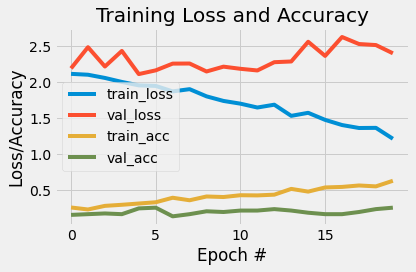

In [83]:
plot_history(H,20)


In [76]:
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=label_names))

              precision    recall  f1-score   support

      Renoir       0.00      0.00      0.00        10
     Matisse       0.00      0.00      0.00        10
    Pissarro       0.50      0.20      0.29        10
      Hassam       0.00      0.00      0.00        10
     VanGogh       0.23      0.30      0.26        10
     Sargent       0.33      0.10      0.15        10
       Degas       0.32      0.70      0.44        10
       Monet       0.17      0.30      0.21        10
     Gauguin       0.30      0.70      0.42        10
     Cezanne       0.33      0.30      0.32        10

    accuracy                           0.26       100
   macro avg       0.22      0.26      0.21       100
weighted avg       0.22      0.26      0.21       100



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
